In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import re
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
import random
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('punkt')
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import itertools
import os
from IPython.display import clear_output

c:\Users\leofr\miniconda3\envs\elmo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leofr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
tf.__version__

'1.15.0'

In [3]:
hub.__version__

'0.13.0'

### Load the corpus

In [4]:
# load_dataset("wikipedia", "20220301.en")
corpus = load_dataset("wikipedia", "20220301.simple")

Found cached dataset wikipedia (C:/Users/leofr/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)
100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


### Load ELMo

In [5]:
elmo = hub.Module("elmo_3", trainable=True)

### Functions

In [6]:
def get_sentences(corpus, concept):
    '''
    Gets all sentences including the exact concept.
    '''

    pattern = r'\b{}\b'.format(concept.lower())  # regex pattern for exact word match (maybe later also include concept + "'s"?)
    sentences = []
    for text in corpus['train']['text']:
        for sentence in re.split('[.!?]', text):
            if re.search(pattern, sentence.lower()):
                sentences.append([sentence])

    print(f'- {len(sentences)} sentences extracted containing the concept {concept}.')

    return sentences

In [7]:
# Variation 1: excluding the other concept
def get_exclude_sentences(corpus, concept, comparison_concept):
    '''
    Gets all sentences of the concept excluding the compared to concept.
    '''

    pattern = r'\b{}\b'.format(concept.lower())
    pattern2 = r'\b{}\b'.format(comparison_concept.lower())
    sentences = []
    for text in corpus['train']['text']:
        for sentence in re.split('[.!?]', text):
            if re.search(pattern, sentence.lower()):
                if re.search(pattern2, sentence.lower()):
                    continue
                else:
                    sentences.append([sentence])

    print(f'- {len(sentences)} sentences extracted containing concept A excluding concept B: {concept}-{comparison_concept}')

    return sentences

In [8]:
# Variation 2: including only sentences with both concepts present
def get_overlap_sentences(corpus, concept, comparison_concept):
    '''
    Gets all sentences including the exact concept and the comparison concept.
    '''
    pattern = r'\b{}\b'.format(concept.lower())
    pattern2 = r'\b{}\b'.format(comparison_concept.lower())
    sentences = []
    for text in corpus['train']['text']:
        for sentence in re.split('[.!?]', text):
            if re.search(pattern, sentence.lower()):
                if re.search(pattern2, sentence.lower()):
                    sentences.append([sentence])
    
    print(f'- {len(sentences)} sentences extracted containing the combination of concepts: {concept}-{comparison_concept}')

    return sentences

In [9]:
def preprocess_sentences(sentences_list, remove_stopword=False):
    
    # Make all words lowercase
    sentences = [[word.lower() for word in sentence] for sentence in sentences_list]

    # Remove stopwords
    if remove_stopword:
        sentences = [[remove_stopwords(word) for word in sentence] for sentence in sentences]

    # Strip the punctuation of the words
    sentences = [[strip_punctuation(word) for word in sentence] for sentence in sentences]

    # Remove numbers
    # sentences = [[word for word in sentence if not word.isdigit()] for sentence in sentences]

    # Lemmatize words
    sentences = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in sentences]

    # Remove sublists to put all sentences in one big list
    sentences = [item for sublist in sentences for item in sublist]

    # Remove any extra white spaces
    sentences = [' '.join(sentence.split()) for sentence in sentences]

    return sentences

In [10]:
def generate_elmo_embeddings(sentences, concept, layer_to_use, batch_size):
    '''
    Creates embeddings for all sentences and only selects those for the selected concept.
    '''

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(tf.compat.v1.tables_initializer())
        
        output = []
        max_len = 0
        for i in range(0, len(sentences), batch_size):
            batch_sentences = sentences[i:i+batch_size]
            embeddings = elmo(batch_sentences, signature="default", as_dict=True)[layer_to_use]
            batch_embeddings = embeddings.eval()
            output.append(batch_embeddings)
            max_len = max(max_len, batch_embeddings.shape[1])

        padded_output = []
        for batch_embeddings in output:
            pad_width = ((0, 0), (0, max_len - batch_embeddings.shape[1]), (0, 0))
            padded_embeddings = np.pad(batch_embeddings, pad_width, mode='constant')
            padded_output.append(padded_embeddings)

        output = np.concatenate(padded_output, axis=0)

    # Extract only embeddings for concept of interest
    concept_embeddings = []
    for i, sentence in enumerate(sentences):
        tokens = sentence.lower().split()
        try:
            concept_index = tokens.index(concept)
            concept_embedding = output[i][concept_index]
            concept_embeddings.append(concept_embedding)
        except:
            print(' - Sentence excluded:', sentence)

    return pd.DataFrame(concept_embeddings, columns=[f"dim{i}" for i in range(1024)])

In [11]:
def horn_parallel_analysis(data, num_iterations=100, scale=True):
    '''
    Perform Horn's Parallel Analysis to get number of components.
    '''

    if scale:
        scaler = StandardScaler(with_mean=True, with_std=True)
        data = scaler.fit_transform(data)

    n, p = data.shape

    # Generate random data with the same dimensions as the input data
    rand_data = np.random.normal(loc=np.mean(data), scale=np.std(data), size=(n, p, num_iterations))

    # Compute the eigenvalues for both the input data and the random data
    pca = PCA(n_components=p)
    pca.fit(data)
    observed_eigenvals = pca.explained_variance_

    rand_eigenvals = np.zeros((p, num_iterations))
    for i in range(num_iterations):
        pca.fit(rand_data[:,:,i])
        rand_eigenvals[:,i] = pca.explained_variance_

    # Compute the 95th percentile of the random eigenvalues
    percentile = np.percentile(rand_eigenvals, 95, axis=1)

    # Determine the number of principal components to keep
    num_components = np.sum(observed_eigenvals > percentile)

    print("Number of principal components to retain:", num_components)

    plot_data = pd.DataFrame({'observed_eigenvals':observed_eigenvals,'percentile':percentile})

    return num_components, plot_data

In [12]:
def create_subspace(sentences_list, concept, sentences_to_include, elmo_layer_to_use, remove_stopword, batch_size):
    
    print('Getting sentences...')
    if len(sentences_list)>=sentences_to_include:
        random.seed(0)
        sentences_list = random.sample(sentences_list, sentences_to_include)
    else:
        print(f'WARNING NOT ENOUGH SENTENCES!')
    print(f'    - {len(sentences_list)} of these sampled.')
    
    print('Preprocessing sentences...')
    sentences = preprocess_sentences(sentences_list, remove_stopword)

    print('Creating embeddings...')
    embeddings = generate_elmo_embeddings(sentences, concept, elmo_layer_to_use, batch_size)

    print('Determining number of components...')
    num_components, plot_data = horn_parallel_analysis(embeddings.T)

    print('Extracting principal components...')
    pca = PCA(n_components=num_components).fit(embeddings.T)
    principal_components = pca.transform(embeddings.T)

    pca_df = pd.DataFrame(principal_components, columns=[f'PC_{i}' for i in range(1, num_components+1)])
    pca_df = pca_df.T
    pca_df.columns = [f'dim{i}' for i in range(len(pca_df.columns))]    

    print('Done :)')
    
    return pca_df

In [13]:
def get_norm(vector):
    return np.sqrt(np.sum(vector**2))

In [14]:
def normalize(subspace):
    subspace_norm = subspace.copy(deep=True)

    for i, basis_vector in enumerate(subspace.to_numpy()):
        subspace_norm.iloc[i] = basis_vector / get_norm(basis_vector)
    
    return subspace_norm

In [15]:
def subspace_similarity(subspace1, subspace2):
    
    # Calculate the projector of each subspace as the sum of outer products of the basis vectors
    Ps1 = sum([np.outer(vec, vec.conj().T) for vec in subspace1]) # Since real values, the conjugate transpose is the same
    Ps2 = sum([np.outer(vec, vec.conj().T) for vec in subspace2])

    # Find the state vector that satisfies ||Ps1 * state_vector||^2 = ||Ps2 * state_vector||^2
    def norm_squared_eqn(state):
        # Calculate norm squared of PS1|ψ⟩ and PS2|ψ⟩
        state = state / get_norm(state)

        norm_squared_PS1 = get_norm(np.dot(Ps1, state))**2
        norm_squared_PS2 = get_norm(np.dot(Ps2, state))**2

        # Return difference between norms squared
        return norm_squared_PS1 - norm_squared_PS2

    # Solve the norm-squared equation using a least squares solver
    np.random.seed(0)
    initial_guess = np.random.rand(subspace1.shape[1])
    solution = least_squares(norm_squared_eqn, initial_guess)
    state = solution.x

    # Normalize the resulting state vector
    state_vector = state / get_norm(state)

    # Calculate similarity as  sim(S1, S2) = ||Ps1 * Ps2 * |ψ⟩||^2
    
    state_on_Ps1 = np.dot(Ps1, state_vector)
    updated_state = state_on_Ps1 / get_norm(state_on_Ps1)
    updated_state_on_Ps2 = np.dot(Ps2, updated_state)
    similarity = get_norm(updated_state_on_Ps2)**2

    # return get_norm(state_on_Ps1)**2 * similarity
    
    return similarity

## Get Subspaces for all Variations

In [17]:
sentences = {
    'innovation': get_sentences(corpus,'innovation'),
    'invention': get_sentences(corpus,'invention'),
    'renovation': get_sentences(corpus,'renovation'),
    'technology': get_sentences(corpus,'technology'),
    'creativity': get_sentences(corpus,'creativity'),
    'implementation': get_sentences(corpus,'implementation'),
    # 'spain-germany_ex': get_exclude_sentences(corpus,'spain','germany'),
    # 'spain-germany_in': get_overlap_sentences(corpus,'spain','germany'),
    # 'spain-spanish_ex': get_exclude_sentences(corpus,'spain','spanish'),
    # 'spain-spanish_in': get_overlap_sentences(corpus,'spain','spanish'),
    # 'germany_spain_ex': get_exclude_sentences(corpus,'germany','spain'),
    # 'spanish_spain_ex': get_exclude_sentences(corpus,'spanish','spain'),
}

- 244 sentences extracted containing the concept innovation.
- 456 sentences extracted containing the concept invention.
- 90 sentences extracted containing the concept renovation.
- 3480 sentences extracted containing the concept technology.
- 115 sentences extracted containing the concept creativity.
- 245 sentences extracted containing the concept implementation.


In [18]:
# Variations
sentences_var = list(sentences.keys())
remove_stopword = [False, True]
elmo_layers = ['elmo','lstm_outputs1','lstm_outputs2']

combinations = list(itertools.product(sentences_var, remove_stopword, elmo_layers))
print(f'Creating {len(combinations)} different subspaces.')

Creating 36 different subspaces.


In [19]:
for j,i in enumerate(combinations):
    print('Iteration:',j)

    file = f"new_subspaces/{i[0]}&{str(i[1])}&{i[2]}.csv"

    if os.path.isfile(file):
        continue    
    else:
        subspace = create_subspace(
            sentences_list=sentences[i[0]],
            concept=i[0].split('-')[0],
            sentences_to_include=300,
            elmo_layer_to_use=i[2],
            remove_stopword=i[1],
            batch_size=32
            )
        subspace.to_csv(file)

    clear_output()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35


## Similarities Main

Import Subspaces

In [24]:
subspaces = []
concepts = []
without_stopwords = []
elmo_layers = []

for filename in os.listdir('new_subspaces'):
    if filename.endswith('.csv'):
        parts = filename.split('&')
        
        concepts.append(parts[0])
        without_stopwords.append(parts[1])
        elmo_layers.append(parts[2].split('.')[0])
        subspaces.append(
            normalize(pd.read_csv('new_subspaces/'+filename, index_col=0)).to_numpy()
            )

all_subspaces = pd.DataFrame({
    'subspace':subspaces,
    'concept':concepts,
    'without_stopword':without_stopwords,
    'elmo_layer':elmo_layers,
    'dimensionality':[s.shape[0] for s in subspaces]})

In [25]:
all_subspaces[['concept','without_stopword','elmo_layer','dimensionality']]

,concept,without_stopword,elmo_layer,dimensionality
0,creativity,False,elmo,3
1,creativity,False,lstm_outputs1,4
2,creativity,False,lstm_outputs2,6
3,creativity,True,elmo,4
4,creativity,True,lstm_outputs1,3
5,creativity,True,lstm_outputs2,6
6,implementation,False,elmo,5
7,implementation,False,lstm_outputs1,4
8,implementation,False,lstm_outputs2,6
9,implementation,True,elmo,5


Get Comparisons to Make

In [26]:
main_concept = 'innovation'

In [27]:
contains_main_concept = np.array([True if main_concept in sublist else False for sublist in all_subspaces.concept.str.split('-')])

comparisons = []
for i, row in all_subspaces[contains_main_concept].iterrows():
    if len(row.concept.split('-'))==1:
        for j, row2 in all_subspaces[~contains_main_concept].iterrows():
            if len(row2.concept.split('-'))==1:
                if (row2.without_stopword==row.without_stopword) & (row2.elmo_layer==row.elmo_layer):
                    comparisons.append((i, j))
    else:
        if row.concept.split('_')[1] == 'ex':
            for j, row2 in all_subspaces[~contains_main_concept].iterrows():
                if row2.concept.split('_')[-1] == 'ex':
                    if (row2.without_stopword==row.without_stopword) & (row2.elmo_layer==row.elmo_layer):
                        comparisons.append((i, j))
            
        elif row.concept.split('_')[1] == 'in':
            for j, row2 in all_subspaces[~contains_main_concept].iterrows():
                if row2.concept.split('_')[1] == 'in':
                    if (row2.without_stopword==row.without_stopword) & (row2.elmo_layer==row.elmo_layer):
                        comparisons.append((i, j))

Calculate Similarities

In [28]:
concept1 = []
concept2 = []
without_stopwords = []
elmo_layers= []
similarities = []

for i in comparisons:
    concept1.append(all_subspaces.concept[i[0]])
    concept2.append(all_subspaces.concept[i[1]])
    without_stopwords.append(all_subspaces.without_stopword[i[0]])
    elmo_layers.append(all_subspaces.elmo_layer[i[0]])
    similarities.append(subspace_similarity(all_subspaces.subspace[i[0]], all_subspaces.subspace[i[1]]))

similarity_df = pd.DataFrame({
    'concept1':concept1,
    'concept2':concept2,
    'without_stopword':without_stopwords,
    'elmo_layer':elmo_layers,
    'similarity':similarities})

In [29]:
similarity_df['variation'] = ['Variation 1'] * 5 + ['Variation 2'] * 5 + ['Variation 3'] * 5 + ['Variation 4'] * 5 + ['Variation 5'] * 5 + ['Variation 6'] * 5
similarity_df

,concept1,concept2,without_stopword,elmo_layer,similarity,variation
0,innovation,creativity,False,elmo,0.136282,Variation 1
1,innovation,implementation,False,elmo,0.185403,Variation 1
2,innovation,invention,False,elmo,0.233581,Variation 1
3,innovation,renovation,False,elmo,0.166009,Variation 1
4,innovation,technology,False,elmo,0.422935,Variation 1
5,innovation,creativity,False,lstm_outputs1,0.535878,Variation 2
6,innovation,implementation,False,lstm_outputs1,0.353114,Variation 2
7,innovation,invention,False,lstm_outputs1,0.425414,Variation 2
8,innovation,renovation,False,lstm_outputs1,0.289304,Variation 2
9,innovation,technology,False,lstm_outputs1,0.511621,Variation 2


In [30]:
similarity_df[similarity_df.variation=='Variation 1'].sort_values('similarity', ascending=False)[['concept2','similarity']]

,concept2,similarity
4,technology,0.422935
2,invention,0.233581
1,implementation,0.185403
3,renovation,0.166009
0,creativity,0.136282


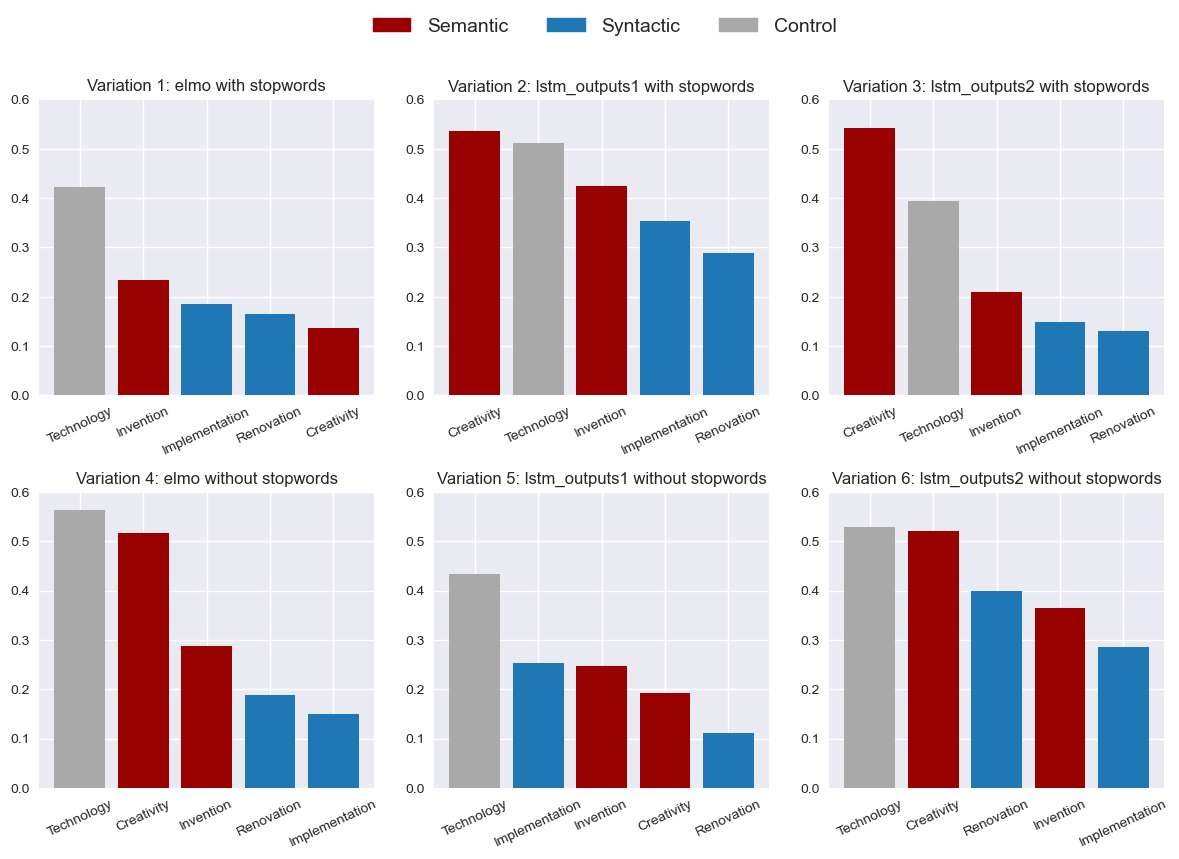

In [32]:
import matplotlib.patches as mpatches

plt.style.use('seaborn')

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

color_map = {'Invention':'#990000', 'Creativity':'#990000', 'Renovation':'#1F77B4', 'Implementation':'#1F77B4', 'Technology':'#A9A9A9'}
color_labels = {'Semantic':'#990000', 'Syntactic':'#1F77B4', 'Control':'#A9A9A9'}


# Plot each method's scores as a bar chart
for i, ax in enumerate(axes.flatten()):
    if i+1 <= 6:
        df = similarity_df[similarity_df.variation == f'Variation {i+1}'].reset_index(drop=True)
        scores = list(df.similarity)
        labels = list(similarity_df.concept2[0:5].str.capitalize())

        # Sort scores in descending order
        sorted_scores, sorted_labels = zip(*sorted(zip(scores, labels), reverse=True))

        categories = [label.split()[-1] for label in sorted_labels]
        colors = [color_map[category] for category in categories]

        # Plot the bar chart
        ax.bar(sorted_labels, sorted_scores, color=colors)

        # Set the title for each subplot
        ax.set_title(f"{df.variation[0]}: {df.elmo_layer[0]} {'with' if df.without_stopword[0]=='False' else 'without'} stopwords", fontsize=12)

# Custom legend
handles = [mpatches.Patch(color=color, label=label) for label, color in color_labels.items()]
legend = fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.3, 1.08), ncol=3, fontsize=14)


# Rotate x labels for all subplots
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=25)
    plt.ylim(0,0.6)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

fig.tight_layout();

## Similarities - Sentence Level

In [33]:
subspaces = []
concepts = []
without_stopwords = []
elmo_layers = []

for filename in os.listdir('new_subspaces_sentence_level'):
    if filename.endswith('.csv'):
        parts = filename.split('&')
        
        concepts.append(parts[0])
        without_stopwords.append(parts[1])
        elmo_layers.append(parts[2].split('.')[0])
        subspaces.append(
            normalize(pd.read_csv('new_subspaces_sentence_level/'+filename, index_col=0)).to_numpy()
            )

all_subspaces = pd.DataFrame({
    'subspace':subspaces,
    'concept':concepts,
    'without_stopword':without_stopwords,
    'elmo_layer':elmo_layers,
    'dimensionality':[s.shape[0] for s in subspaces]})

all_subspaces[['concept','without_stopword','elmo_layer','dimensionality']]

,concept,without_stopword,elmo_layer,dimensionality
0,creativity,False,elmo,3
1,creativity,False,lstm_outputs1,3
2,creativity,False,lstm_outputs2,8
3,creativity,True,elmo,2
4,creativity,True,lstm_outputs1,3
5,creativity,True,lstm_outputs2,6
6,implementation,False,elmo,5
7,implementation,False,lstm_outputs1,4
8,implementation,False,lstm_outputs2,7
9,implementation,True,elmo,4


In [34]:
main_concept = 'innovation'

contains_main_concept = np.array([True if main_concept in sublist else False for sublist in all_subspaces.concept.str.split('-')])

comparisons = []
for i, row in all_subspaces[contains_main_concept].iterrows():
    if len(row.concept.split('-'))==1:
        for j, row2 in all_subspaces[~contains_main_concept].iterrows():
            if len(row2.concept.split('-'))==1:
                if (row2.without_stopword==row.without_stopword) & (row2.elmo_layer==row.elmo_layer):
                    comparisons.append((i, j))
    else:
        if row.concept.split('_')[1] == 'ex':
            for j, row2 in all_subspaces[~contains_main_concept].iterrows():
                if row2.concept.split('_')[-1] == 'ex':
                    if (row2.without_stopword==row.without_stopword) & (row2.elmo_layer==row.elmo_layer):
                        comparisons.append((i, j))
            
        elif row.concept.split('_')[1] == 'in':
            for j, row2 in all_subspaces[~contains_main_concept].iterrows():
                if row2.concept.split('_')[1] == 'in':
                    if (row2.without_stopword==row.without_stopword) & (row2.elmo_layer==row.elmo_layer):
                        comparisons.append((i, j))

In [35]:
concept1 = []
concept2 = []
without_stopwords = []
elmo_layers= []
similarities = []

for i in comparisons:
    concept1.append(all_subspaces.concept[i[0]])
    concept2.append(all_subspaces.concept[i[1]])
    without_stopwords.append(all_subspaces.without_stopword[i[0]])
    elmo_layers.append(all_subspaces.elmo_layer[i[0]])
    similarities.append(subspace_similarity(all_subspaces.subspace[i[0]], all_subspaces.subspace[i[1]]))

similarity_df_sentence = pd.DataFrame({
    'concept1':concept1,
    'concept2':concept2,
    'without_stopword':without_stopwords,
    'elmo_layer':elmo_layers,
    'similarity':similarities})

similarity_df_sentence

,concept1,concept2,without_stopword,elmo_layer,similarity
0,innovation,creativity,False,elmo,0.821208
1,innovation,implementation,False,elmo,0.396225
2,innovation,invention,False,elmo,0.626546
3,innovation,renovation,False,elmo,0.589122
4,innovation,technology,False,elmo,0.646399
5,innovation,creativity,False,lstm_outputs1,0.852522
6,innovation,implementation,False,lstm_outputs1,0.675999
7,innovation,invention,False,lstm_outputs1,0.543796
8,innovation,renovation,False,lstm_outputs1,0.526057
9,innovation,technology,False,lstm_outputs1,0.556573


In [36]:
similarity_df_sentence['variation'] = ['Variation 1'] * 5 + ['Variation 2'] * 5 + ['Variation 3'] * 5 + ['Variation 4'] * 5 + ['Variation 5'] * 5 + ['Variation 6'] * 5

In [37]:
similarity_df_sentence[(similarity_df_sentence.without_stopword=='False')&(similarity_df_sentence.elmo_layer=='elmo')].sort_values('similarity', ascending=False)

,concept1,concept2,without_stopword,elmo_layer,similarity,variation
0,innovation,creativity,False,elmo,0.821208,Variation 1
4,innovation,technology,False,elmo,0.646399,Variation 1
2,innovation,invention,False,elmo,0.626546,Variation 1
3,innovation,renovation,False,elmo,0.589122,Variation 1
1,innovation,implementation,False,elmo,0.396225,Variation 1


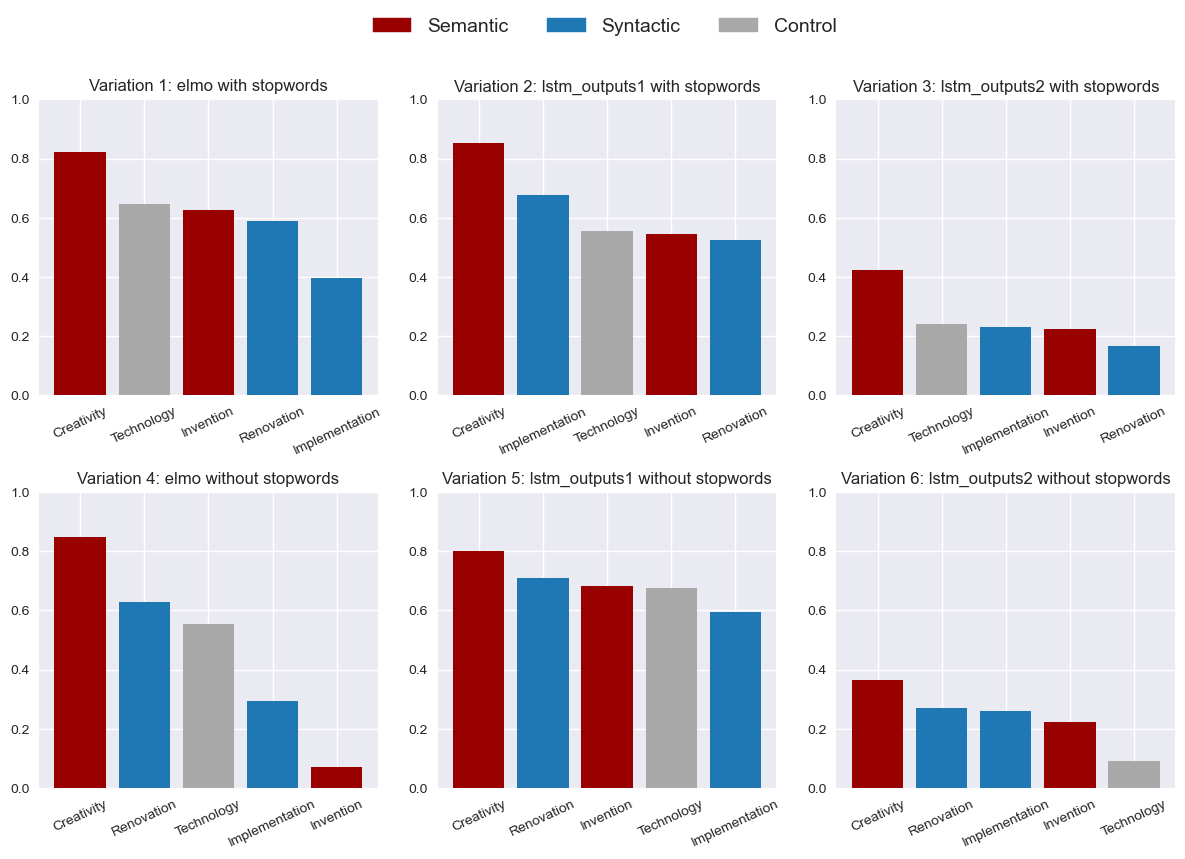

In [38]:
import matplotlib.patches as mpatches

plt.style.use('seaborn')

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

color_map = {'Invention':'#990000', 'Creativity':'#990000', 'Renovation':'#1F77B4', 'Implementation':'#1F77B4', 'Technology':'#A9A9A9'}
color_labels = {'Semantic':'#990000', 'Syntactic':'#1F77B4', 'Control':'#A9A9A9'}


# Plot each method's scores as a bar chart
for i, ax in enumerate(axes.flatten()):
    if i+1 <= 6:
        df = similarity_df_sentence[similarity_df_sentence.variation == f'Variation {i+1}'].reset_index(drop=True)
        scores = list(df.similarity)
        labels = list(similarity_df.concept2[0:5].str.capitalize())

        # Sort scores in descending order
        sorted_scores, sorted_labels = zip(*sorted(zip(scores, labels), reverse=True))

        categories = [label.split()[-1] for label in sorted_labels]
        colors = [color_map[category] for category in categories]

        # Plot the bar chart
        ax.bar(sorted_labels, sorted_scores, color=colors)

        # Set the title for each subplot
        ax.set_title(f"{df.variation[0]}: {df.elmo_layer[0]} {'with' if df.without_stopword[0]=='False' else 'without'} stopwords", fontsize=12)

# Custom legend
handles = [mpatches.Patch(color=color, label=label) for label, color in color_labels.items()]
legend = fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.3, 1.08), ncol=3, fontsize=14)


# Rotate x labels for all subplots
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=25)
    plt.ylim(0,1)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

fig.tight_layout();

## Similarities - Word2Vec (skip gram)

In [37]:
subspaces = []
concepts = []
without_stopwords = []

for filename in os.listdir('new_subspaces_word2vec'):
    if filename.endswith('.csv'):
        parts = filename.split('&')
        
        concepts.append(parts[0])
        without_stopwords.append(parts[1])
        subspaces.append(
            normalize(pd.read_csv('new_subspaces_word2vec/'+filename, index_col=0)).to_numpy()
            )

all_subspaces = pd.DataFrame({
    'subspace':subspaces,
    'concept':concepts,
    'without_stopword':without_stopwords,
    'dimensionality':[s.shape[0] for s in subspaces]})

all_subspaces[['concept','dimensionality']]

,concept,dimensionality
0,creativity,6
1,implementation,4
2,innovation,6
3,invention,5
4,renovation,3
5,technology,5


In [38]:
main_concept = 'innovation'

contains_main_concept = np.array([True if main_concept in sublist else False for sublist in all_subspaces.concept.str.split('-')])

comparisons = []
for i, row in all_subspaces[contains_main_concept].iterrows():
    for j, row2 in all_subspaces[~contains_main_concept].iterrows():
        comparisons.append((i, j))

comparisons

[(2, 0), (2, 1), (2, 3), (2, 4), (2, 5)]

In [40]:
concept1 = []
concept2 = []
similarities = []

for i in comparisons:
    concept1.append(all_subspaces.concept[i[0]])
    concept2.append(all_subspaces.concept[i[1]])
    similarities.append(subspace_similarity(all_subspaces.subspace[i[0]], all_subspaces.subspace[i[1]]))

similarity_df_word2vec = pd.DataFrame({
    'concept1':concept1,
    'concept2':concept2,
    'similarity':similarities})

similarity_df_word2vec

,concept1,concept2,similarity
0,innovation,creativity,0.333380
1,innovation,implementation,0.550777
2,innovation,invention,0.297333
3,innovation,renovation,0.329364
4,innovation,technology,0.162742


In [142]:
similarity_df_word2vec['variation'] = ['Variation 1'] * 5

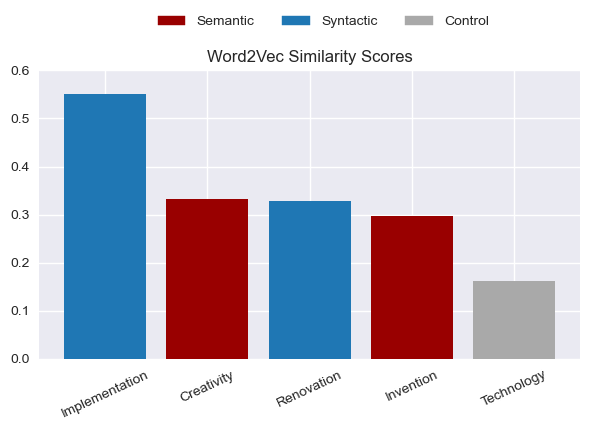

In [155]:
import matplotlib.patches as mpatches

plt.style.use('seaborn')

# Create the subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

color_map = {'Invention':'#990000', 'Creativity':'#990000', 'Renovation':'#1F77B4', 'Implementation':'#1F77B4', 'Technology':'#A9A9A9'}
color_labels = {'Semantic':'#990000', 'Syntactic':'#1F77B4', 'Control':'#A9A9A9'}

scores = list(similarity_df_word2vec.similarity)
labels = list(similarity_df.concept2[0:5].str.capitalize())

# Sort scores in descending order
sorted_scores, sorted_labels = zip(*sorted(zip(scores, labels), reverse=True))

categories = [label.split()[-1] for label in sorted_labels]
colors = [color_map[category] for category in categories]

# Plot the bar chart
ax.bar(sorted_labels, sorted_scores, color=colors)

# Set the title for each subplot
ax.set_title(f"Word2Vec Similarity Scores", fontsize=12)

# Custom legend
handles = [mpatches.Patch(color=color, label=label) for label, color in color_labels.items()]
legend = fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.25, 1.08), ncol=3, fontsize=10)


# Rotate x labels for all subplots
plt.xticks(rotation=25)
plt.ylim(0,0.6)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

fig.tight_layout();

## Similarities -  Glove CBOW

In [16]:
subspaces = []
concepts = []
without_stopwords = []

for filename in os.listdir('new_subspaces_word2vec2'):
    if filename.endswith('.csv'):
        parts = filename.split('&')
        
        concepts.append(parts[0])
        without_stopwords.append(parts[1])
        subspaces.append(
            normalize(pd.read_csv('new_subspaces_word2vec2/'+filename, index_col=0)).to_numpy()
            )

all_subspaces = pd.DataFrame({
    'subspace':subspaces,
    'concept':concepts,
    'without_stopword':without_stopwords,
    'dimensionality':[s.shape[0] for s in subspaces]})

all_subspaces[['concept','dimensionality']]

,concept,dimensionality
0,creativity,5
1,implementation,3
2,innovation,4
3,invention,5
4,renovation,4
5,technology,4


In [17]:
main_concept = 'innovation'

contains_main_concept = np.array([True if main_concept in sublist else False for sublist in all_subspaces.concept.str.split('-')])

comparisons = []
for i, row in all_subspaces[contains_main_concept].iterrows():
    for j, row2 in all_subspaces[~contains_main_concept].iterrows():
        comparisons.append((i, j))

comparisons

[(2, 0), (2, 1), (2, 3), (2, 4), (2, 5)]

In [18]:
concept1 = []
concept2 = []
similarities = []

for i in comparisons:
    concept1.append(all_subspaces.concept[i[0]])
    concept2.append(all_subspaces.concept[i[1]])
    similarities.append(subspace_similarity(all_subspaces.subspace[i[0]], all_subspaces.subspace[i[1]]))

similarity_df_word2vec2 = pd.DataFrame({
    'concept1':concept1,
    'concept2':concept2,
    'similarity':similarities})

similarity_df_word2vec2

,concept1,concept2,similarity
0,innovation,creativity,0.710073
1,innovation,implementation,0.522791
2,innovation,invention,0.300766
3,innovation,renovation,0.530803
4,innovation,technology,0.601622


In [19]:
similarity_df_word2vec2['variation'] = ['Variation 1'] * 5

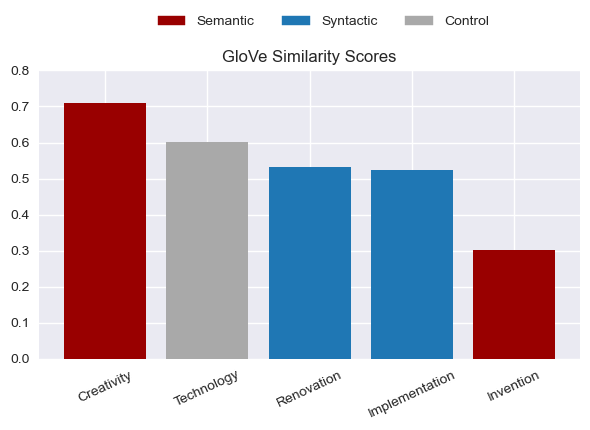

In [39]:
import matplotlib.patches as mpatches

plt.style.use('seaborn')

# Create the subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

color_map = {'Invention':'#990000', 'Creativity':'#990000', 'Renovation':'#1F77B4', 'Implementation':'#1F77B4', 'Technology':'#A9A9A9'}
color_labels = {'Semantic':'#990000', 'Syntactic':'#1F77B4', 'Control':'#A9A9A9'}

scores = list(similarity_df_word2vec2.similarity)
labels = list(similarity_df_word2vec2.concept2[0:5].str.capitalize())

# Sort scores in descending order
sorted_scores, sorted_labels = zip(*sorted(zip(scores, labels), reverse=True))

categories = [label.split()[-1] for label in sorted_labels]
colors = [color_map[category] for category in categories]

# Plot the bar chart
ax.bar(sorted_labels, sorted_scores, color=colors)

# Set the title for each subplot
ax.set_title(f"GloVe Similarity Scores", fontsize=12)

# Custom legend
handles = [mpatches.Patch(color=color, label=label) for label, color in color_labels.items()]
legend = fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.25, 1.08), ncol=3, fontsize=10)


# Rotate x labels for all subplots
plt.xticks(rotation=25)
plt.ylim(0,0.8)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

fig.tight_layout();

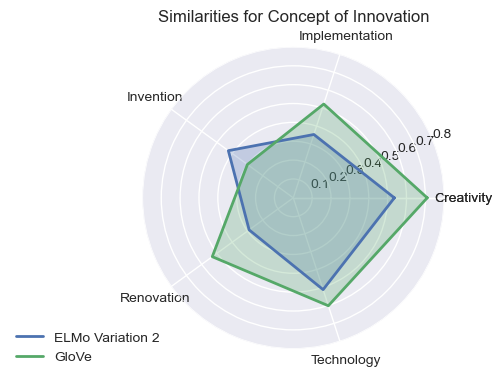

In [45]:
# Compute the angle for each axis in the plot
angles = np.linspace(0, 2*np.pi, 5, endpoint=False)

# Close the plot by repeating the first angle
angles = np.concatenate((angles, [angles[0]]))

# Create the radar chart
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, polar=True)

# Plot each method's scores as a line
scores = list(similarity_df[similarity_df.variation == f'Variation 2'].similarity)
scores = np.concatenate((scores, [scores[0]]))
ax.plot(angles, scores, linewidth=2, label=f'ELMo Variation 2')
ax.fill(angles, scores, alpha=0.25)

scores = list(similarity_df_word2vec2.similarity)
scores = np.concatenate((scores, [scores[0]]))
ax.plot(angles, scores, linewidth=2, label=f'GloVe')
ax.fill(angles, scores, alpha=0.25)

# Set the labels for each axis
labels = list(similarity_df.concept2[0:6].str.capitalize())
ax.set_thetagrids(angles * 180/np.pi, labels)

# Set the maximum value for each axis
ax.set_rmax(0.8)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

fig.tight_layout();
# Add the legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1));
plt.title('Similarities for Concept of Innovation');

### Horn's Plot

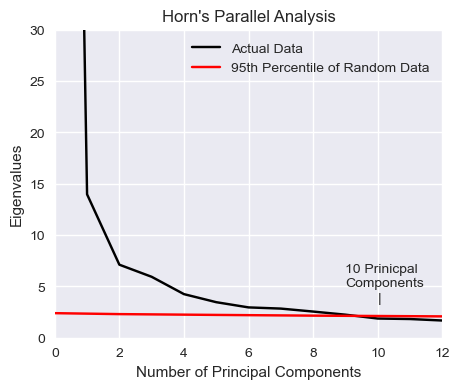

In [37]:
plt.subplots(figsize=(5,4))
plt.style.use('seaborn')
plt.plot(plot_data.observed_eigenvals, color='black', label='Actual Data')
plt.plot(plot_data.percentile, color='red', label = '95th Percentile of Random Data')
plt.title("Horn's Parallel Analysis")
plt.ylabel('Eigenvalues')
plt.xlabel('Number of Principal Components')
plt.xlim(0,12)
plt.ylim(0,30)
plt.annotate('10 Prinicpal\nComponents',(9,5))
plt.annotate('|',(10,3.5))
plt.legend();